# Data Exploration

 This part is intended to explore data used to create a model that predicts which passengers survived the Titanic shipwreck.

## Variable Notes

Data Dictionary

| Variable   | Definition                          | Key                             |
|------------|-------------------------------------|---------------------------------|
| survival   | Survival                            | 0 = No, 1 = Yes                 |
| pclass     | Ticket class                        | 1 = 1st, 2 = 2nd, 3 = 3rd       |
| sex        | Sex                                 |                                 |
| Age        | Age in years                        |                                 |
| sibsp      | # of siblings / spouses aboard the Titanic |                         |
| parch      | # of parents / children aboard the Titanic |                         |
| ticket     | Ticket number                       |                                 |
| fare       | Passenger fare                      |                                 |
| cabin      | Cabin number                        |                                 |
| embarked   | Port of Embarkation                 | C = Cherbourg, Q = Queenstown, S = Southampton |

pclass: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.




In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
pd.set_option('display.max_columns', 500)

## A first look at the data

In this first phase we will take a look at the data structure, if there are any missing values and how the values are distributed among the different features. Then, we will hopefully get some useful insights for choosing which features to use to create our model and, if useful, creating new features (feature engineering). 

In [2]:
df_train_filepath = r'..\dataset\train.csv'
df_train = pd.read_csv(df_train_filepath)

df_test_filepath = r'..\dataset\test.csv'
df_test = pd.read_csv(df_test_filepath)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's understand how many missing data are present in our dataset

In [4]:
def list_missing(data, verbose=True):
    mis_cols = [col for col in data.columns if data[col].isna().any() > 0]
    if not verbose:
        return mis_cols
    for col in mis_cols:
        print(f'{col}: {round(data[col].isna().sum() / data.shape[0] * 100, 2)}% missing values')
    return mis_cols

list_missing(df_train)

Age: 19.87% missing values
Cabin: 77.1% missing values
Embarked: 0.22% missing values


['Age', 'Cabin', 'Embarked']

We can appreciate that there are many missing values for the cabin data. This means that mostly of the passengers did not have any cabin. Thus, it could be useful to create a new flag feature to understand whether passengers without a cabin had more chance of survival.

In [5]:
mis_train = list_missing(df_train)
print('_'*40)
print('\n')
mis_test = list_missing(df_test)

Age: 19.87% missing values
Cabin: 77.1% missing values
Embarked: 0.22% missing values
________________________________________


Age: 20.57% missing values
Fare: 0.24% missing values
Cabin: 78.23% missing values


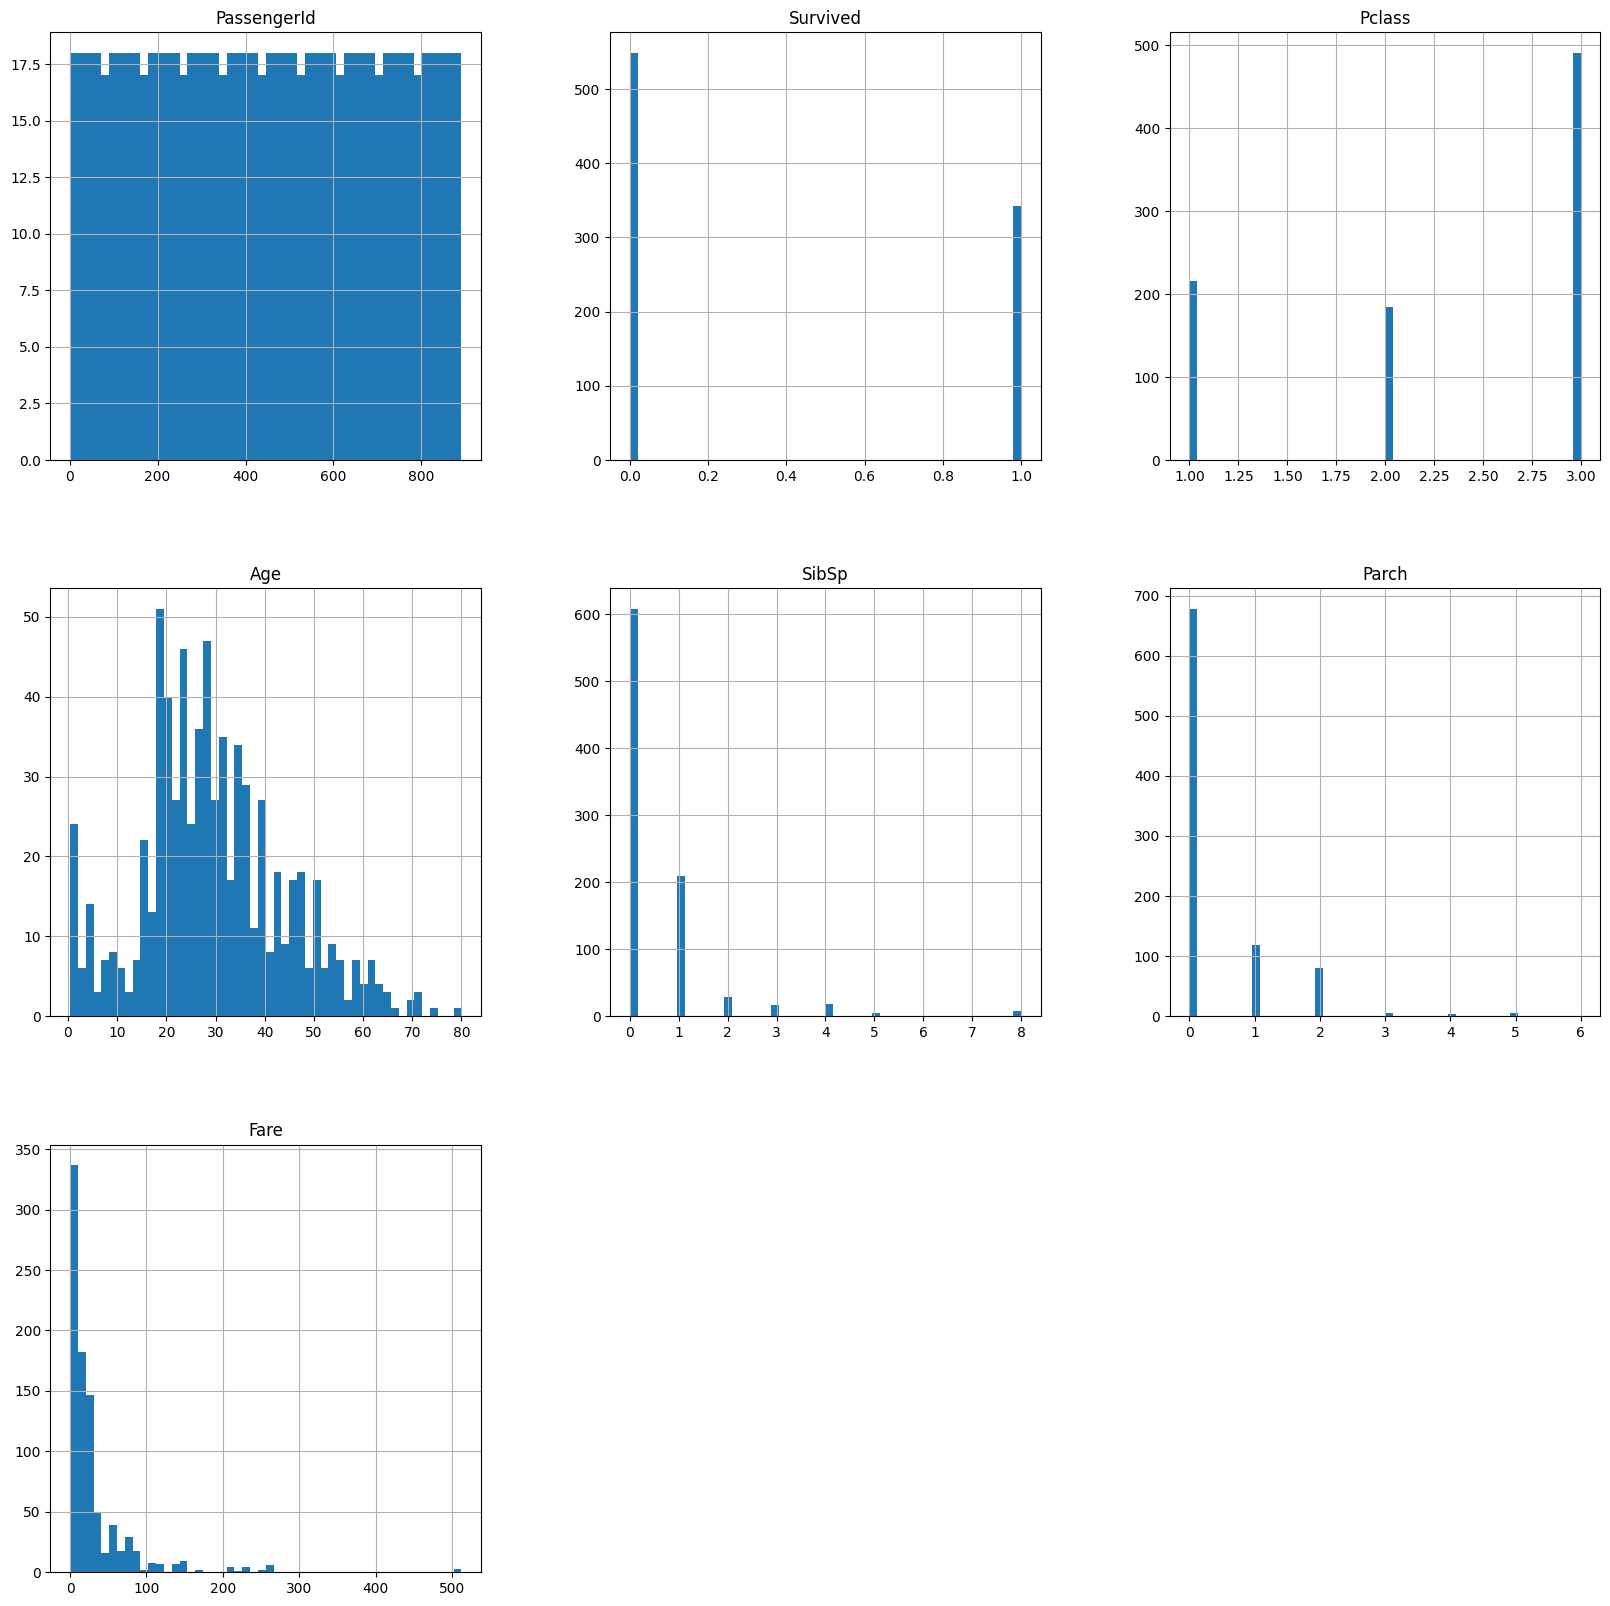

In [6]:
df_train.hist(figsize=(20, 20), bins=50)
plt.show()

Let's try to drop some feature that could not be useful for the prediction

In [7]:
df_train_processed = df_train.copy()
df_train_processed.drop(columns=['PassengerId', 'Cabin', 'Ticket', 'Name'], inplace=True)
df_train_processed.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


and we can also one-hot encode our categorical variables through the get_dummies() method

In [8]:
df_train_processed = pd.get_dummies(df_train_processed, drop_first=False)
df_train_processed.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


Now let's take a look at the correlation of the different features with the target column Survived

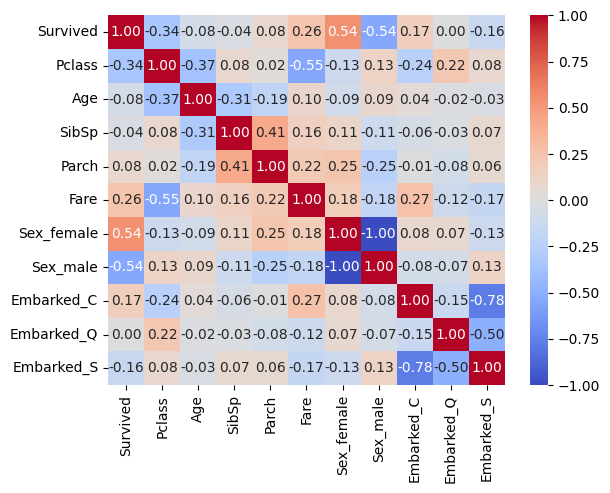

In [9]:
df_train_processed.corr()['Survived'].sort_values(ascending=False)
plt.Figure(figsize=(20, 20))
sns.heatmap(df_train_processed.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

Looking at the correlation matrix we can notice that the survival has quite good correlation with some features like pclass, fare, sex and the embark location while it looks like there is low-to-no correlation with age, sibsp (siblings/spouse) and Parch (parents/children). Moreover, one feature between Sex_female and Sex_male can be dropped.

In order to plot the correlation matrix, the cabin feature has been dropped before. Now let get back at it as it may be an important feature to predict the survival of the passengers. Indeed, it is interesting to understand if passengers with cabin had more chances of survival and also whether there was a safer area of the ship.

Let's try to plot the different cabins with the survival information

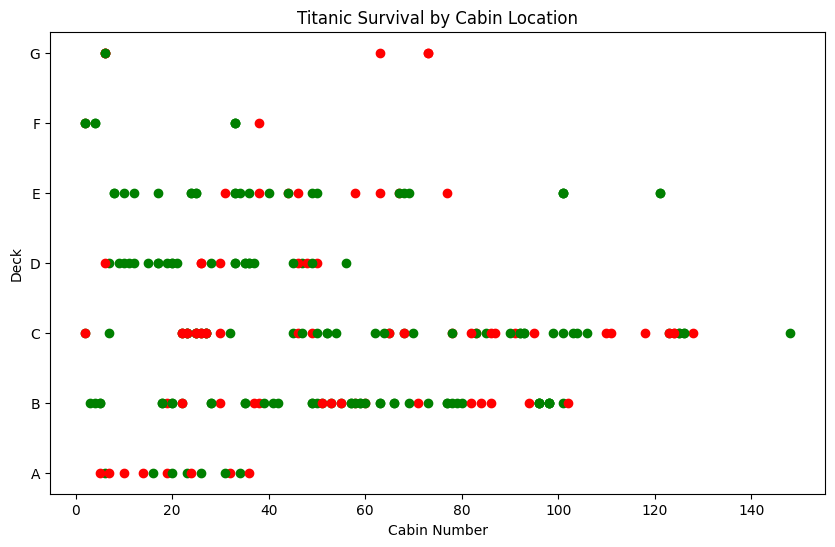

In [10]:
import re

# Function to extract individual cabin assignments
def extract_cabins(cabin_str):
    if pd.isna(cabin_str):
        return []
    return re.findall(r'([A-Z])(\d+)', cabin_str)

# Expand the dataframe so each row represents a single cabin
expanded_rows = []
for _, row in df_train.iterrows():
    cabins = extract_cabins(row['Cabin'])
    for deck, number in cabins:
        expanded_rows.append({'Deck': deck, 'Number': int(number), 'Survived': row['Survived']})

expanded_df = pd.DataFrame(expanded_rows)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot: Survived (green), Not Survived (red)
colors = {1: 'green', 0: 'red'}
for _, row in expanded_df.iterrows():
    ax.scatter(row['Number'], ord(row['Deck']), color=colors[row['Survived']], label=row['Deck'])

ax.set_yticks([ord(d) for d in sorted(expanded_df['Deck'].unique())])
ax.set_yticklabels(sorted(expanded_df['Deck'].unique()))
ax.set_xlabel("Cabin Number")
ax.set_ylabel("Deck")
ax.set_title("Titanic Survival by Cabin Location")
plt.show()

As we can appreciate from the plot, there was no cabin number nor deck with higher probabilites to survive than the others. Thus, we can simplify this feature and create a new one determining whether a passenger had a cabin or not.

In [11]:
df_train_processed['_hasCabin'] = df_train['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
df_train_processed.head()
df_train_processed.drop(columns=['Sex_male'], inplace=True)

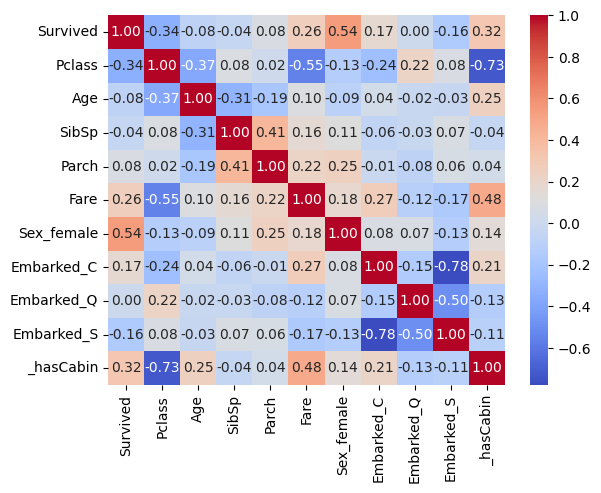

In [12]:
df_train_processed.corr()['Survived'].sort_values(ascending=False)
plt.Figure(figsize=(20, 20))
sns.heatmap(df_train_processed.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

The siblings/spouse and parents/children freatures look like have no correlation with the target. Let's try to create a new feature combining them as an index of how a family is large

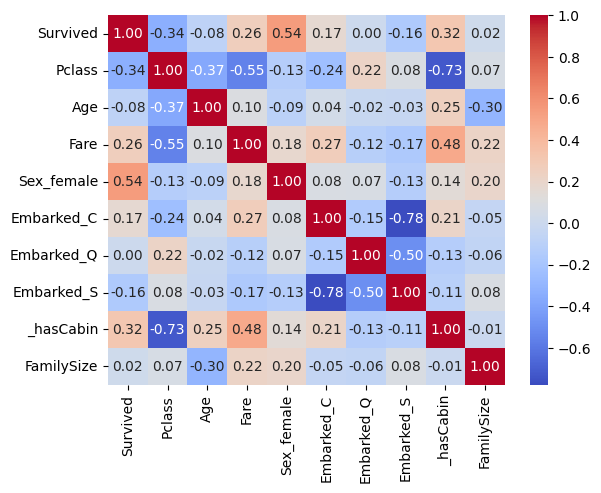

In [13]:
df_train_processed['FamilySize'] = df_train_processed['SibSp'] + df_train_processed['Parch']
df_train_processed.drop(columns=['SibSp', 'Parch'], inplace=True)
df_train_processed.head()

plt.Figure(figsize=(20, 20))
sns.heatmap(df_train_processed.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

Let's check if creating a new feature combining family size and age would improve the correlation

In [14]:
def fam_age(data):
    df = data.copy()
    df.loc[(df['FamilySize'] > 2) & (df['Age'] > 10), 'Fam_Age'] = 'bigfamily_adult'
    df.loc[(df['FamilySize'] > 2) & (df['Age'] <= 10), 'Fam_Age'] = 'bigfamily_child'
    df.loc[(df['FamilySize'] <= 2) & (df['Age'] > 10), 'Fam_Age'] = 'smallfamily_adult'
    df.loc[(df['FamilySize'] <= 2) & (df['Age'] <= 10), 'Fam_Age'] = 'smallfamily_child'

    return df

df_train_processed['Age'] = df_train_processed['Age'].fillna(df_train_processed['Age'].mean())
list_missing(df_train_processed)


[]

In [15]:
df_train_processed = fam_age(df_train_processed)
df_train_processed = pd.get_dummies(df_train_processed, drop_first=False)
df_train_processed.head()


,Survived,Pclass,Age,Fare,Sex_female,Embarked_C,Embarked_Q,Embarked_S,_hasCabin,FamilySize,Fam_Age_bigfamily_adult,Fam_Age_bigfamily_child,Fam_Age_smallfamily_adult,Fam_Age_smallfamily_child
0,0,3,22.0,7.2500,False,False,False,True,0,1,False,False,True,False
1,1,1,38.0,71.2833,True,True,False,False,1,1,False,False,True,False
2,1,3,26.0,7.9250,True,False,False,True,0,0,False,False,True,False
3,1,1,35.0,53.1000,True,False,False,True,1,1,False,False,True,False
4,0,3,35.0,8.0500,False,False,False,True,0,0,False,False,True,False


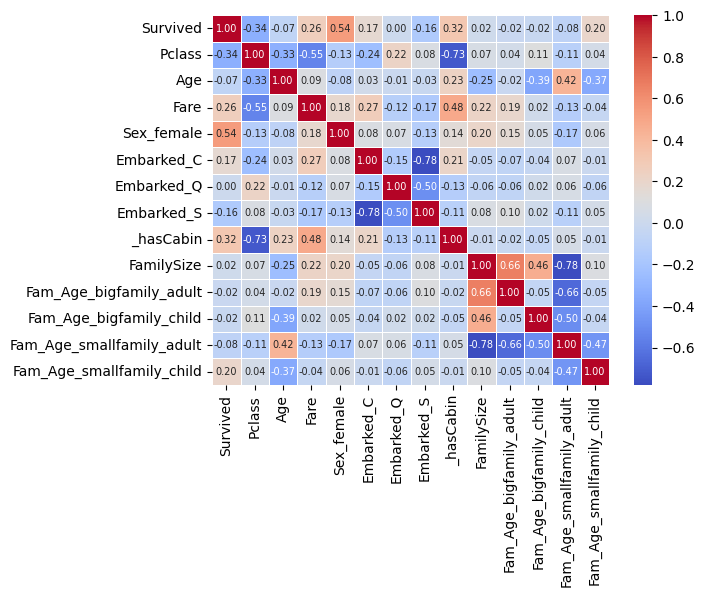

In [16]:
%matplotlib inline 
plt.Figure(figsize=(10, 8))
sns.heatmap(df_train_processed.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 7})
plt.show()

We found out that the survival of children with a small family is slightly correlated with the survival target, let's try to keep the new features and drop the old ones

In [17]:
df_train_processed.drop(columns=['Age', 'FamilySize'], inplace=True)
df_train_processed.head()

,Survived,Pclass,Fare,Sex_female,Embarked_C,Embarked_Q,Embarked_S,_hasCabin,Fam_Age_bigfamily_adult,Fam_Age_bigfamily_child,Fam_Age_smallfamily_adult,Fam_Age_smallfamily_child
0,0,3,7.2500,False,False,False,True,0,False,False,True,False
1,1,1,71.2833,True,True,False,False,1,False,False,True,False
2,1,3,7.9250,True,False,False,True,0,False,False,True,False
3,1,1,53.1000,True,False,False,True,1,False,False,True,False
4,0,3,8.0500,False,False,False,True,0,False,False,True,False


# Model Creation

Now let's try to implement our first model using a Random Forest Classifier and tuning its parameters using a Random Search algorithm

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df_train_processed['Survived'] = df_train_processed['Survived'].astype(bool)
train = df_train_processed.drop(columns=['Survived'])
target = df_train_processed['Survived']

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define cross-validation strategy
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=cv_folds, verbose=2, random_state=42, n_jobs=-1)

# Perform the RandomizedSearchCV
random_search.fit(train, target)

# Print the best parameters found
best_rf = random_search.best_estimator_
print('Best Hyperparameters:', random_search.best_params_)
print('Best CV score:', random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Best CV score: 0.8350448810495262


# Inference

Now we want to evaluate the best model we found on the test dataset (unseen data) to check how it performs

In [19]:
df_test_processed = df_test.copy()
df_test_processed.drop(columns=['PassengerId', 'Cabin', 'Ticket', 'Name'], inplace=True)
df_test_processed = pd.get_dummies(df_test_processed, drop_first=False)

In [20]:
df_test_processed['_hasCabin'] = df_test['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
df_test_processed.drop(columns=['Sex_male'], inplace=True)
df_test_processed['FamilySize'] = df_test_processed['SibSp'] + df_test_processed['Parch']
df_test_processed.drop(columns=['SibSp', 'Parch'], inplace=True)
df_test_processed['Age'] = df_test_processed['Age'].fillna(df_test_processed['Age'].mean())
df_test_processed['Fare'] = df_test_processed['Fare'].fillna(df_test_processed['Fare'].mean())
df_test_processed = fam_age(df_test_processed)
df_test_processed = pd.get_dummies(df_test_processed, drop_first=False)
df_test_processed.drop(columns=['Age', 'FamilySize'], inplace=True)

In [21]:
predictions = best_rf.predict(df_test_processed)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
output['Survived'] = output['Survived'].astype(int)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
